In [49]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from helper import get_performance

EPOCHS = 700
BATCH_SIZE = 2048
ACTIVATION = 'swish'
LEARNING_RATE = 0.0007
FOLDS = 5

In [50]:
data_dir = "dataset/Water_Quality/"
data = pd.read_csv(data_dir + "water_potability.csv")
data = data.sample(frac=1, replace=True, random_state=1).reset_index(drop=True)
data = data.dropna()
label = data.columns[-1]
features = data.columns[:-1]
# Separate the data
X, y = data[features], data[label]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [51]:
y_train.value_counts()

0    826
1    496
Name: Potability, dtype: int64

In [52]:
y_test.value_counts()

0    391
1    261
Name: Potability, dtype: int64

In [53]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(1322, 9) (1322,) (652, 9) (652,)


# Default Model

In [54]:
model_default = DecisionTreeClassifier()
scores_default = cross_val_score(model_default, X=X_train, y=y_train, cv = FOLDS)
model_default.fit(X_train, y_train)
y_pred_default = model_default.predict(X_test)
get_performance(X_test, y_test, y_pred_default)

Performance on all data
Precision: 0.7501790643524155
Recall: 0.7515337423312883
F1 Score: 0.7506759141452872


(0.7501790643524155, 0.7515337423312883, 0.7506759141452872, None)

In [55]:
pd.DataFrame(y_pred_default).value_counts()

0    401
1    251
dtype: int64

# SMOTE Oversampling

In [56]:
# SMOTE Oversampling
    # Transform data 
oversample = SMOTE()
X_train_sm, y_train_sm = oversample.fit_resample(X_train, y_train)
model_SMOTE = DecisionTreeClassifier()
scores_SMOTE = cross_val_score(model_SMOTE, X=X_train_sm, y=y_train_sm, cv = FOLDS)
model_SMOTE.fit(X_train_sm, y_train_sm)
y_pred_SMOTE = model_SMOTE.predict(X_test)
get_performance(X_test, y_test, y_pred_SMOTE)

Performance on all data
Precision: 0.7342229769954317
Recall: 0.7331288343558282
F1 Score: 0.7336134293731061


(0.7342229769954317, 0.7331288343558282, 0.7336134293731061, None)

In [57]:
print(X_train_sm.shape,y_train_sm.shape)

(1652, 9) (1652,)


# MAPS

In [58]:
import time 
import sys
sys.path.insert(1, './mmd')
from mmd import diagnoser
from scipy import stats as st
import numpy
#notebook's library
%matplotlib inline
from helper import get_top_f1_rules, get_relevent_attributs_target, get_MMD_results, get_biased_features, get_BGMD_results
from helper import generateTrain_data_Weights

In [59]:
default_result = pd.concat([X_test, y_test], axis=1, join='inner')
default_result.loc[:,"pred"] = y_pred_default

In [60]:
def mispredict_label(row):
    if row['Potability'] == row['pred']:
        return False
    return True

In [61]:
default_result_copy = default_result.copy()
X_test_copy = X_test.copy()
X_test_copy['mispredict'] = default_result_copy.apply(lambda row: mispredict_label(row), axis=1)

In [62]:
# Get relevent attributes and target 
relevant_attributes, Target = get_relevent_attributs_target(X_test_copy)
# Generate MMD rules and correspodning information
MMD_rules, MMD_time, MMD_Features = get_MMD_results(X_test_copy, relevant_attributes, Target)

#Get biased attributes this time 
biased_attributes = get_biased_features(X_test_copy, relevant_attributes)

BGMD_rules, BGMD_time, BGMD_Features = get_BGMD_results(X_test_copy, biased_attributes, Target)

print('MMD Spent:', MMD_time, 'BGMD Spent:', BGMD_time)
MMD_rules, BGMD_rules

MMD Spent: 6.222815275192261 BGMD Spent: 0.1064462661743164


([[0.40995607613469986, 'Sulfate>300.7637719072286'],
  [0.3851508120649652, 'Sulfate>340.10602778835107'],
  [0.02395209580838323, 'Turbidity>5.771714760283059']],
 [[0.40995607613469986, 'Sulfate>300.7637719072286'],
  [0.3851508120649652, 'Sulfate>340.10602778835107'],
  [0.38129496402877694, 'Sulfate>324.33620298187776']])

In [63]:
from helper import get_test_data_in_misprediction_areas

final_result = pd.concat([X_test, y_test], axis=1, join='inner')

indexes_in_misprediction_area = get_test_data_in_misprediction_areas(BGMD_rules, X_test)
y_actual_MD = []

for index in indexes_in_misprediction_area:
        y_actual_MD.append(final_result.loc[index]['Potability'])

In [64]:
from collections import Counter
from sklearn.metrics import precision_recall_fscore_support
grid_upweights = range(1, 101)
best_weight_all = 1
best_f1_all = 0
best_weight_mis = 1
best_f1_mis = 0
f1_all = []
f1_mispredicted = []
acc_all = []
acc_mispredicted = []
recall_all = []
recall_mispredicted = []
for upweight in grid_upweights:
    # give extra weights to training samples in mispredited areas 
    print('Upweight_value: ', upweight)
    weights = generateTrain_data_Weights(BGMD_rules, X_train, upweight_value=upweight)

    c = Counter(weights)
    print(c.items())

    MAPS_model = DecisionTreeClassifier()
    scores_MAPS = cross_val_score(MAPS_model, X=X_train, y=y_train, cv = FOLDS)
    MAPS_model.fit(X_train, y_train, sample_weight = weights)

    y_pred_MAPS = MAPS_model.predict(X_test)

    total_result = get_performance(X_test, y_test, y_pred_MAPS)
    
    acc_all.append(total_result[0])
    recall_all.append(total_result[1])
    f1_all.append(total_result[2])
    
    final_result['y_pred_MAPS'] = y_pred_MAPS
    y_pred_MAPS_MD = []
    for index in indexes_in_misprediction_area:
        y_pred_MAPS_MD.append(final_result.loc[index]['y_pred_MAPS'])
    MAPS_MD_metric = precision_recall_fscore_support(y_actual_MD, y_pred_MAPS_MD, average='weighted')
    acc_mispredicted.append(MAPS_MD_metric[0])
    recall_mispredicted.append(MAPS_MD_metric[1])
    f1_mispredicted.append(MAPS_MD_metric[2])
    
    if total_result[2] > best_f1_all:
        best_f1_all = total_result[2]
        best_weight_all = upweight;
    if MAPS_MD_metric[2] > best_f1_mis:
        best_f1_mis = MAPS_MD_metric[2]
        best_weight_mis = upweight

Upweight_value:  1
dict_items([(1, 1322)])
Performance on all data
Precision: 0.7590705216364456
Recall: 0.7607361963190185
F1 Score: 0.7595433328178985
Upweight_value:  2
dict_items([(2, 1072), (1, 250)])
Performance on all data
Precision: 0.744735151158675
Recall: 0.7438650306748467
F1 Score: 0.7442559771112406
Upweight_value:  3
dict_items([(3, 1072), (1, 250)])
Performance on all data
Precision: 0.7411576177282121
Recall: 0.7423312883435583
F1 Score: 0.7416307360663856
Upweight_value:  4
dict_items([(4, 1072), (1, 250)])
Performance on all data
Precision: 0.7733052467309237
Recall: 0.7730061349693251
F1 Score: 0.7731483115925583
Upweight_value:  5
dict_items([(5, 1072), (1, 250)])
Performance on all data
Precision: 0.7694624884718714
Recall: 0.7714723926380368
F1 Score: 0.7694704044372708
Upweight_value:  6
dict_items([(6, 1072), (1, 250)])
Performance on all data
Precision: 0.7618371194975568
Recall: 0.7622699386503068
F1 Score: 0.7620371188118654
Upweight_value:  7
dict_items([(7

Performance on all data
Precision: 0.7547083905625248
Recall: 0.7561349693251533
F1 Score: 0.7552015705235634
Upweight_value:  52
dict_items([(52, 1072), (1, 250)])
Performance on all data
Precision: 0.7551615196411021
Recall: 0.7561349693251533
F1 Score: 0.7555594182049762
Upweight_value:  53
dict_items([(53, 1072), (1, 250)])
Performance on all data
Precision: 0.7682598405100597
Recall: 0.7684049079754601
F1 Score: 0.768330537396592
Upweight_value:  54
dict_items([(54, 1072), (1, 250)])
Performance on all data
Precision: 0.7570886650073473
Recall: 0.7576687116564417
F1 Score: 0.7573496886708144
Upweight_value:  55
dict_items([(55, 1072), (1, 250)])
Performance on all data
Precision: 0.76853774457846
Recall: 0.7699386503067485
F1 Score: 0.7689705450568909
Upweight_value:  56
dict_items([(56, 1072), (1, 250)])
Performance on all data
Precision: 0.7515337423312883
Recall: 0.7515337423312883
F1 Score: 0.7515337423312883
Upweight_value:  57
dict_items([(57, 1072), (1, 250)])
Performance o

Best weight on all is:  32
Best weight on misprediction area is:  78


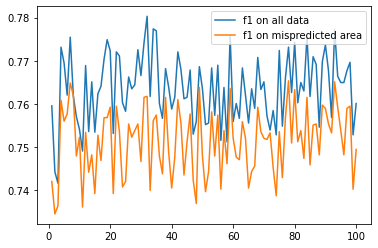

In [65]:
print("Best weight on all is: ", best_weight_all)
print("Best weight on misprediction area is: ", best_weight_mis)
plt.plot(grid_upweights, f1_all, label = "f1 on all data")
plt.plot(grid_upweights, f1_mispredicted, label = "f1 on mispredicted area")
plt.legend()
plt.show()

In [66]:
from helper import get_mispredicted_region_test

weights = generateTrain_data_Weights(BGMD_rules, X_train, upweight_value=best_weight_mis)
c = Counter(weights)
MAPS_model = DecisionTreeClassifier()
scores_MAPS = cross_val_score(MAPS_model, X=X_train, y=y_train, cv = FOLDS)
MAPS_model.fit(X_train, y_train, sample_weight = weights)
y_pred_MAPS = MAPS_model.predict(X_test)
get_performance(X_test, y_test, y_pred_MAPS)

default_MD_metric, SMOTE_MD_metric, MAPS_MD_metric = get_mispredicted_region_test(X_test, y_test, y_pred_default, y_pred_SMOTE, y_pred_MAPS, BGMD_rules, ylabel='Potability')

Performance on all data
Precision: 0.7682598405100597
Recall: 0.7684049079754601
F1 Score: 0.768330537396592
y_actual_MD: 521
y_predict_default_MD: 521
y_pred_SMOTE_MD: 521
y_pred_MAPS_MD: 521

Default: (0.7302853590965145, 0.7312859884836852, 0.7307418109721372, None)
SMOTE: (0.7195702956449286, 0.7140115163147792, 0.7160327686044202, None)
MAPS: (0.759405941490889, 0.7600767754318618, 0.7597155600241916, None)


In [67]:
dict = {'acc_all': acc_all, 'recall_all': recall_all, 'f1_all': f1_all, 'acc_mispredicted': acc_mispredicted, 'recall_mispredicted': recall_mispredicted, 'f1_mispredicted': f1_mispredicted}
out = pd.DataFrame(dict)
out.to_csv('MAPS_Water_Quality_DT.csv')

# Just Train Twice

In [68]:
from helper import generate_JTT_Weights

In [69]:
X_train_1st, X_val, y_train_1st, y_val = train_test_split(X_train, y_train, test_size = 0.33, random_state = 29)

model_JTT = DecisionTreeClassifier()
scores_JTT_1st = cross_val_score(model_JTT, X_train_1st, y=y_train_1st, cv = FOLDS)
model_JTT.fit(X_train_1st, y_train_1st)
y_pred_JTT_val = model_JTT.predict(X_val)
get_performance(X_val, y_val, y_pred_JTT_val)

Performance on all data
Precision: 0.7149748707237503
Recall: 0.7139588100686499
F1 Score: 0.7144329927020259


(0.7149748707237503, 0.7139588100686499, 0.7144329927020259, None)

In [70]:
grid_upweights_JTT = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]
best_weight_all_JTT = 1
best_f1_all_JTT = 0
f1_all_JTT = [];

for upweight in grid_upweights_JTT:
    weights = generate_JTT_Weights(y_val.to_list(), y_pred_JTT_val, weight = upweight)
    
    #combine train and validate data
    weights = np.concatenate((np.ones(len(X_train_1st)), weights))
    y_train_2nd = np.concatenate((y_train_1st, y_val))
    X_train_2nd = pd.concat([X_train_1st, X_val])
    X_train_2nd['val_weight'] = weights
    X_train_2nd['target'] = y_train_2nd
    X_train_2nd = X_train_2nd.sample(frac=1, random_state=1).reset_index(drop=True)
    weights = X_train_2nd['val_weight'].to_list()
    y_train_2nd = X_train_2nd['target']
    X_train_2nd = X_train_2nd.drop(['val_weight', 'target'], axis=1)
    
    model_JTT = DecisionTreeClassifier()
    scores_JTT_2nd = cross_val_score(model_JTT, X_train_2nd, y=y_train_2nd, cv = FOLDS)
    model_JTT.fit(X_train_2nd, y_train_2nd, sample_weight = weights)
    y_pred_JTT = model_JTT.predict(X_test)
    total_result_JTT = get_performance(X_test, y_test, y_pred_JTT)
    f1_all_JTT.append(total_result_JTT[2])
    if total_result_JTT[2] > best_f1_all_JTT:
        best_f1_all_JTT = total_result_JTT[2]
        best_weight_all_JTT = upweight;

Performance on all data
Precision: 0.7683747191550442
Recall: 0.7699386503067485
F1 Score: 0.7687916661710562
Performance on all data
Precision: 0.7551103079475522
Recall: 0.7515337423312883
F1 Score: 0.7527478880930202
Performance on all data
Precision: 0.7709060292433837
Recall: 0.7699386503067485
F1 Score: 0.7703564046319881
Performance on all data
Precision: 0.7559361574434034
Recall: 0.7530674846625767
F1 Score: 0.754101668461598
Performance on all data
Precision: 0.7633292453262837
Recall: 0.7607361963190185
F1 Score: 0.7616801202957605
Performance on all data
Precision: 0.7520677600278867
Recall: 0.7484662576687117
F1 Score: 0.7496953928842921
Performance on all data
Precision: 0.7382698369657323
Recall: 0.7315950920245399
F1 Score: 0.7334898914727485
Performance on all data
Precision: 0.7475088399690656
Recall: 0.7423312883435583
F1 Score: 0.7439151489040606
Performance on all data
Precision: 0.7389386511852224
Recall: 0.7331288343558282
F1 Score: 0.7348706652365243
Performance

JTT Best weight on all is:  30
JTT Best f1 score on all:  0.7703564046319881


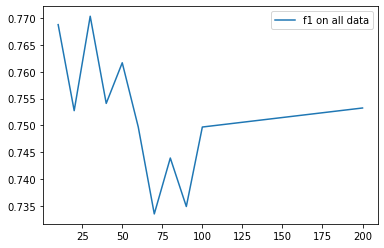

In [71]:
print("JTT Best weight on all is: ", best_weight_all_JTT)
print("JTT Best f1 score on all: ", best_f1_all_JTT)
plt.plot(grid_upweights_JTT, f1_all_JTT, label = "f1 on all data")
plt.legend()
plt.show()

In [72]:
weights = generate_JTT_Weights(y_val.to_list(), y_pred_JTT_val, weight = best_weight_all_JTT)
    
#combine train and validate data
weights = np.concatenate((np.ones(len(X_train_1st)), weights))
y_train_2nd = np.concatenate((y_train_1st, y_val))
X_train_2nd = pd.concat([X_train_1st, X_val])
X_train_2nd['val_weight'] = weights
X_train_2nd['target'] = y_train_2nd
X_train_2nd = X_train_2nd.sample(frac=1, random_state=1).reset_index(drop=True)
weights = X_train_2nd['val_weight'].to_list()
y_train_2nd = X_train_2nd['target']
X_train_2nd = X_train_2nd.drop(['val_weight', 'target'], axis=1)

model_JTT = DecisionTreeClassifier()
scores_JTT_2nd = cross_val_score(model_JTT, X_train_2nd, y=y_train_2nd, cv = FOLDS)
model_JTT.fit(X_train_2nd, y_train_2nd, sample_weight = weights)
y_pred_JTT = model_JTT.predict(X_test)
total_result_JTT = get_performance(X_test, y_test, y_pred_JTT)
    

default_MD_metric, SMOTE_MD_metric, MAPS_MD_metric = get_mispredicted_region_test(X_test, y_test, y_pred_JTT, y_pred_SMOTE, y_pred_MAPS, BGMD_rules, ylabel='Potability')

Performance on all data
Precision: 0.7733710516818934
Recall: 0.7714723926380368
F1 Score: 0.7722003345619454
y_actual_MD: 521
y_predict_default_MD: 521
y_pred_SMOTE_MD: 521
y_pred_MAPS_MD: 521

Default: (0.7650659031634794, 0.7581573896353166, 0.7602584177111907, None)
SMOTE: (0.7195702956449286, 0.7140115163147792, 0.7160327686044202, None)
MAPS: (0.759405941490889, 0.7600767754318618, 0.7597155600241916, None)
